In [3]:
# Mount your own google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/CSM146_PS2')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
"""
Author      : Yi-Chieh Wu, Sriram Sankararaman
"""

# This code was adapted from course material by Jenna Wiens (UMichigan).

# python libraries
import os
import time

# numpy libraries
import numpy as np

# matplotlib libraries
import matplotlib.pyplot as plt

In [4]:
######################################################################
# classes
######################################################################

class Data :

    def __init__(self, X=None, y=None) :
        """
        Data class.

        Attributes
        --------------------
            X       -- numpy array of shape (n,d), features
            y       -- numpy array of shape (n,), targets
        """

        # n = number of examples, d = dimensionality
        self.X = X
        self.y = y

    def load(self, filename) :
        """
        Load csv file into X array of features and y array of labels.

        Parameters
        --------------------
            filename -- string, filename
        """

        # load data
        with open(filename, 'r') as fid :
            data = np.loadtxt(fid, delimiter=",")

        # separate features and labels
        self.X = data[:,:-1]
        self.y = data[:,-1]

    def plot(self, **kwargs) :
        """Plot data."""

        if 'color' not in kwargs :
            kwargs['color'] = 'b'

        plt.scatter(self.X, self.y, **kwargs)
        plt.xlabel('x', fontsize = 16)
        plt.ylabel('y', fontsize = 16)
        plt.show()

# wrapper functions around Data class
def load_data(filename) :
    data = Data()
    data.load(filename)
    return data

def plot_data(X, y, **kwargs) :
    data = Data(X, y)
    data.plot(**kwargs)

In [71]:
class PolynomialRegression() :

    def __init__(self, m=1) :
        """
        Ordinary least squares regression.

        Attributes
        --------------------
            coef_   -- numpy array of shape (d,)
                       estimated coefficients for the linear regression problem
            m_      -- integer
                       order for polynomial regression
        """
        self.coef_ = None
        self.m_ = m


    def generate_polynomial_features(self, X) :
        """
        Maps X to an mth degree feature vector e.g. [1, X, X^2, ..., X^m].

        Parameters
        --------------------
            X       -- numpy array of shape (n,1), features

        Returns
        --------------------
            Phi     -- numpy array of shape (n,(m+1)), mapped features
        """

        n,d = X.shape

        ### ==================== ###
        # part b: modify to create matrix for simple linear model
        # X = np.append(np.ones([n,1]), X, 1)

        # part g: modify to create matrix for polynomial model
        m = self.m_
        Phi = np.ones([n,1])
        for i in range(1, m + 1):
          Phi = np.append(Phi, X ** i, 1)


        ### ==================== ###

        return Phi


    def fit_GD(self, X, y, eta=None,
                eps=0, tmax=10000, verbose=False) :
        """
        Finds the coefficients of a {d-1}^th degree polynomial
        that fits the data using least squares batch gradient descent.

        Parameters
        --------------------
            X       -- numpy array of shape (n,d), features
            y       -- numpy array of shape (n,), targets
            eta     -- float, step size
            eps     -- float, convergence criterion
            tmax    -- integer, maximum number of iterations
            verbose -- boolean, for debugging purposes

        Returns
        --------------------
            self    -- an instance of self
        """

        if verbose :
            plt.subplot(1, 2, 2)
            plt.xlabel('iteration')
            plt.ylabel(r'$J(\theta)$')
            plt.ion()
            plt.show()

        X = self.generate_polynomial_features(X) # map features
        n,d = X.shape
        eta_input = eta
        self.coef_ = np.zeros(d)                 # coefficients
        err_list  = np.zeros((tmax,1))           # errors per iteration

        # GD loop
        for t in range(tmax) :
            ### ==================== ###
            # part f: update step size
            # change the default eta in the function signature to 'eta=None'
            # and update the line below to your learning rate function
            if eta_input is None:
                eta = 1/(float(1+t))
            else:
                eta = eta_input
            ### ==================== ###

            ### ==================== ###
            # part d: update theta (self.coef_) using one step of GD
            # hint: you can write simultaneously update all theta using vector math
            weights = np.array(list(self.coef_))
            for ind, val in enumerate(self.coef_):
              tot = 0
              for j, x in enumerate(X):
                tot += (np.dot(weights, x) - y[j]) * x[ind] # wj <- wj - 2x_n * sum(h_w(x_n)-y_n)x_nj
              # change the weights
              self.coef_[ind] += (-2) * eta * tot

            # track error
            # hint: you cannot use self.predict(...) to make the predictions
            y_pred = np.dot(X, np.transpose(self.coef_))
            err_list[t] = np.sum(np.power(y - y_pred, 2)) / float(n)
            ### ==================== ###

            # stop?
            if t > 0 and abs(err_list[t] - err_list[t-1]) <= eps :
                break

            # debugging
            if verbose :
                x = np.reshape(X[:,1], (n,1))
                cost = self.cost(x,y)
                plt.subplot(1, 2, 1)
                plt.cla()
                plot_data(x, y)
                self.plot_regression()
                plt.subplot(1, 2, 2)
                plt.plot([t+1], [cost], 'bo')
                plt.suptitle('iteration: %d, cost: %f' % (t+1, cost))
                plt.draw()
                plt.pause(0.05) # pause for 0.05 sec

        print('number of iterations: %d'%(t+1))

        return self


    def fit(self, X, y) :
        """
        Finds the coefficients of a {d-1}^th degree polynomial
        that fits the data using the closed form solution.

        Parameters
        --------------------
            X       -- numpy array of shape (n,d), features
            y       -- numpy array of shape (n,), targets

        Returns
        --------------------
            self    -- an instance of self
        """

        X = self.generate_polynomial_features(X) # map features

        ### ==================== ###
        # part e: implement closed-form solution
        # hint: use np.dot(...) and np.linalg.pinv(...)
        #       be sure to update self.coef_ with your solution
        self.coef_ = (np.linalg.pinv(np.dot(np.transpose(X),X)).dot(np.transpose(X))).dot(y)
        ### ==================== ###


    def predict(self, X) :
        """
        Predict output for X.

        Parameters
        --------------------
            X       -- numpy array of shape (n,d), features

        Returns
        --------------------
            y       -- numpy array of shape (n,), predictions
        """
        if self.coef_ is None :
            raise Exception("Model not initialized. Perform a fit first.")

        X = self.generate_polynomial_features(X) # map features

        ### ==================== ###
        # part c: predict y
        y = np.dot(X, np.transpose(self.coef_))
        ### ==================== ###

        return y


    def cost(self, X, y) :
        """
        Calculates the objective function.

        Parameters
        --------------------
            X       -- numpy array of shape (n,d), features
            y       -- numpy array of shape (n,), targets

        Returns
        --------------------
            cost    -- float, objective J(theta)
        """
        ### ==================== ###
        # part d: compute J(theta)
        cost = 0

        h = self.predict(X)
        for ind, j in enumerate(h):
          cost += (h[ind] - y[ind]) ** 2
        ### ==================== ###
        return cost


    def rms_error(self, X, y) :
        """
        Calculates the root mean square error.

        Parameters
        --------------------
            X       -- numpy array of shape (n,d), features
            y       -- numpy array of shape (n,), targets

        Returns
        --------------------
            error   -- float, RMSE
        """
        ### ==================== ###
        # part h: compute RMSE
        error = np.sqrt(self.cost(X, y)/len(X))
        ### ==========  ========== ###
        return error


    def plot_regression(self, xmin=0, xmax=1, n=50, **kwargs) :
        """Plot regression line."""
        if 'color' not in kwargs :
            kwargs['color'] = 'r'
        if 'linestyle' not in kwargs :
            kwargs['linestyle'] = '-'

        X = np.reshape(np.linspace(0,1,n), (n,1))
        y = self.predict(X)
        plot_data(X, y, **kwargs)
        plt.show()

(20, 1) (20,)
(20, 1) (20,)
Visualizing Train Data


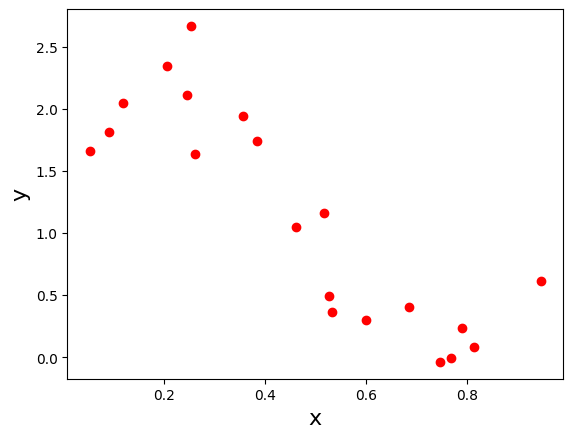

Visualizing Test Data


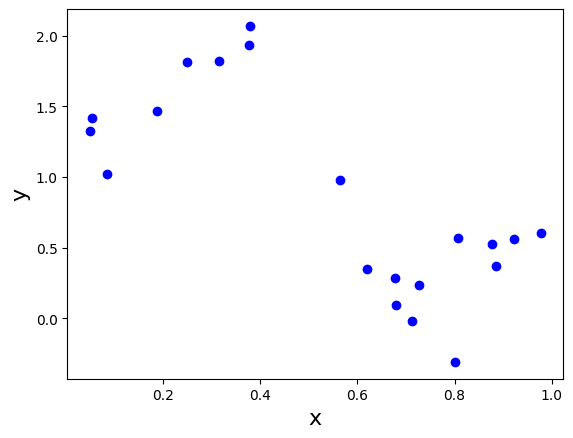

Investigating linear regression...
40.233847409671
model.coef_:[ 2.44640709 -2.81635359]	model_cost:3.912576405791464	run time:0.00023055076599121094
PART F
number of iterations: 1356
model.coef_:[ 2.44640676 -2.81635292]	model_cost:3.912576405792083	run time:0.10002756118774414
Investigating polynomial regression...
Investigating polynomial regression...


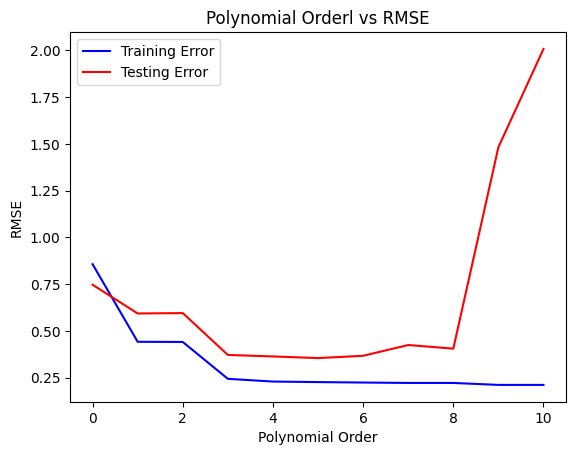

Done!


In [72]:
######################################################################
# main
######################################################################

def main() :
    # load data
    #Use the abs path on your own Google Drive
    train_data = load_data('/content/gdrive/MyDrive/CSM146_PS2/regression_train.csv')
    test_data = load_data('/content/gdrive/MyDrive/CSM146_PS2/regression_test.csv')

    print(train_data.X.shape, train_data.y.shape)
    print(test_data.X.shape, test_data.y.shape)


    ### ==================== ###
    # part a: main code for visualizations
    print('Visualizing Train Data')
    plot_data(train_data.X, train_data.y, color='red')
    print("Visualizing Test Data")
    plot_data(test_data.X, test_data.y, color="blue")


    ### ==================== ###



    ### ==================== ###
    # parts b-f: main code for linear regression
    print('Investigating linear regression...')
    model=PolynomialRegression()
    model.coef_=np.zeros(2)
    print(model.cost(train_data.X,train_data.y))
    '''  eta_list = [pow(10, -4), pow(10, -3), pow(10, -2), 0.1]
    for e in eta_list:
      start_time = time.time()
      model.fit_GD(train_data.X, train_data.y, eta=e)
      stop_time = time.time()
      run_time = stop_time - start_time
      print(f"eta: {e}\tmodel.coef_:{model.coef_}\tmodel_cost:{model.cost(train_data.X, train_data.y)}\trun time:{run_time}")
    '''

    start_time = time.time()
    model.fit(train_data.X, train_data.y)
    stop_time = time.time()
    run_time = stop_time - start_time
    print(f"model.coef_:{model.coef_}\tmodel_cost:{model.cost(train_data.X, train_data.y)}\trun time:{run_time}")

    print("PART F")
    start_time = time.time()
    model.fit_GD(train_data.X, train_data.y)
    stop_time = time.time()
    run_time = stop_time - start_time
    print(f"model.coef_:{model.coef_}\tmodel_cost:{model.cost(train_data.X, train_data.y)}\trun time:{run_time}")

    ### ==================== ###



    ### ========== TODO : START ========== ###
    # parts g-i: main code for polynomial regression
    print('Investigating polynomial regression...')
    print("Investigating polynomial regression...")
    train = []
    test = []

    #set up values
    X_train = train_data.X
    y_train = train_data.y
    X_test = test_data.X
    y_test = test_data.y
    x_val = np.arange(11)

    for deg in range(11):
      model = PolynomialRegression(deg)
      model.fit(X_train, y_train)
      train.append(model.rms_error(X_train, y_train))
      test.append(model.rms_error(X_test, y_test))

    plt.plot(x_val, train, color = "blue", label="Training Error")
    plt.plot(x_val, test, color = "red", label="Testing Error")
    plt.xlabel("Polynomial Order")
    plt.ylabel("RMSE")
    plt.title("Polynomial Orderl vs RMSE")
    plt.legend()
    plt.show()

    ### ========== TODO : END ========== ###




    print("Done!")

if __name__ == "__main__":
    main()
